In [79]:
import requests
import random
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import ast
import json
import time
import datetime
from gdeltdoc import GdeltDoc, Filters
import re
import datetime

In [2]:
# pip install gdeltdoc

## NYTimes API

In [71]:
# pip install --upgrade pynytimes

In [87]:
# !pip3 install requests-html

In [106]:
from pynytimes import NYTAPI
nyt = NYTAPI("rrHIfoqwqciGjJ4C5OGeE9p79VdvzOfp", parse_dates=True)

In [74]:
import datetime

articles = nyt.article_search(
    query = "Ukraine",
    results = 30,
    dates = {
        "begin": datetime.datetime(2022, 2, 24),
        "end": datetime.datetime(2022, 3, 24)
    },
    options = {
        "sort": "oldest",
        "sources": [
            "New York Times",
            # "AP",
            # "Reuters",
            # "International Herald Tribune"
        ],
        # "news_desk": [
        #     "Politics"
        # ],
        # "type_of_material": [
        #     "News Analysis"
        # ]
    }
)

# Article scrape

## Handle scraped text

In [150]:
def get_article_text(soup, newsOutlet):
    # Prensa Latina (Cuba)
    if newsOutlet == 'plenglish.com':
        elts = soup.find_all('div', attrs={'class' : 'elementor-widget-container'})
        first_sent = ''
        for e in elts:
            if '(Prensa Latina)' in e.text:
                first_sent = e.text.strip()
        ps = soup.find_all('p')
        p_text = [first_sent]
        for p in ps:
            if p.text.count('/') >= 2:
                break
            if 'class' in p.attrs:
                break
            p_text.append(p.text)
    # Al Jazeera (Qatar)
    if newsOutlet == 'aljazeera.com':
        ps = soup.find_all('p')
        p_text = []
        if len(ps) > 4:
            for p in ps:
                if 'Follow Al Jazeera English' not in p.text:
                    p_text.append(p.text.strip())
        else:
            uls = soup.find_all('ul')
            for ul in uls:
                lis = ul.find_all('li')
                for li in lis:
                    if '.' in li.text:
                        p_text.append(li.text.strip())
    # People's Daily (China)
    if newsOutlet == 'en.people.cn':
        ps = soup.find_all('p')
        p_text = [p.text.strip().replace("\'", "'") for p in ps]
    # BBC (UK)
    if newsOutlet == 'bbc.co.uk':
        p_text = []
        lastfour = False
        ps = soup.find_all('p')
        endat = len(ps)
        for i, p in enumerate(ps):
            if 'class' in p.attrs and 'Paragraph' in p.attrs['class'][0]:
                if 'You may also be interested in' in p.text:
                    endat = i
                    break
                else:
                    lastfour = True
        if lastfour:
            for p in ps[:-6]:
                if 'class' in p.attrs and 'Paragraph' in p.attrs['class'][0]:
                    p_text.append(p.text.strip().replace("\'", "'"))
        else:
            for p in ps[:i]:
                if 'class' in p.attrs and 'Paragraph' in p.attrs['class'][0]:
                    p_text.append(p.text.strip().replace("\'", "'"))
    # The Punch (Nigeria)
    if newsOutlet == 'punchng.com': 
        postContent = soup.find_all(attrs={'class','post-content'})[0]
        # ps = postContent.find_all('p')
        ad = "(adsbygoogle = window.adsbygoogle || []).push({});"
        postText = postContent.text.replace(ad, '').strip()
        # take out related News
        x = re.search(r"Related News.*?\n", postText) 
        if x:
            relatedNews = x.group(0)
            postText = postText.replace(relatedNews.strip(), '')
        copyrightPunch1 = "Copyright PUNCH"
        copyrightPunch2 = "All rights reserved. This material, and other digital content on this website, may not be reproduced, published, broadcast, rewritten or redistributed in whole or in part without prior express written permission from PUNCH."
        postText = postText.replace(copyrightPunch1,'')
        postText = postText.replace(copyrightPunch2,'')
        p_text = [postText]

    # CNN (US)
    if newsOutlet == 'cnn.com':
        ps = soup.find_all(attrs={'class' : 'zn-body__paragraph'})
        if ps == []:
            ps = soup.find_all(attrs={'class' : 'BasicArticle__paragraph'})
            
        p_text = [p.text.strip() for p in ps if p != '(CNN)']
    # Breitbart (US)
    if newsOutlet == 'breitbart.com':
        ps = soup.find_all('p')
        p_text = [p.text.replace(u'\xa0', u' ') for p in ps[:-5] if 'on Facebook and Twitter.' not in p.text]
        
    # Sputnik (Russia)
    if newsOutlet == 'sputniknews.com':
        articleAnnounceText = soup.find_all('div', {'class' : 'article__announce-text'})[0].text
        if articleAnnounceText == None:
            articleAnnounceText = ''
        article_blocks = soup.find_all("div", {"class": "article__block"})
        p_text = [articleAnnounceText]
        for ab in article_blocks:
            if "Sputnik's live feed and Telegram channels" in ab.text:
                break
            if '@context' in ab.text:
                continue
            p_text.append(ab.text.strip())
            
    if newsOutlet == 'english.pravda.ru':
        ps = soup.find_all('p')
        p_text = []
        for p in ps:
            if 'Subscribe to Pravda.Ru Telegram channel, Facebook, Twitter, YouTube, RSS!' in p.text:
                break
            p_text.append(p.text)
        
    if newsOutlet == 'foxnews.com':
        json_object = json.loads(soup.find_all('script')[3].text, strict=False)
        text = json_object['articleBody'].replace('&nbsp;  ','\n\n').replace('&nbsp;',' ')
                                      
    text = ' '.join([p.strip() for p in p_text])

    return text

## Web Scrape Function

In [151]:
newsDict = dict()

In [152]:
newsOutletList = ['plenglish.com','aljazeera.com','en.people.cn','bbc.co.uk',
                  'punchng.com','cnn.com','breitbart.com','sputniknews.com','english.pravda.ru','foxnews.com']
rangeList = [
    ("2022-01-01", "2022-01-31"),
    ("2022-02-01", "2022-02-29"),
    ("2022-03-01", "2022-03-31"),
    ("2022-04-01", "2022-04-30"),
    ("2022-05-01", "2022-05-31"),
    ("2022-06-01", "2022-06-30"),
]
startStart = time.time()
for newsOutlet in newsOutletList[8:9]:
    startOutlet = time.time()
    newsDict.setdefault(newsOutlet, [])
    print(newsOutlet)
    for start_date, end_date in random.sample(rangeList,1):
        parsed = 0
        f = Filters(
            keyword = "ukraine",
            start_date = start_date,
            end_date = end_date,
            domain_exact = newsOutlet,
            num_records = 250
        )

        gd = GdeltDoc()

        # Search for articles matching the filters
        articles = gd.article_search(f)
        articleDictList = articles.to_dict('records')

        start = time.time()
        for i, artRec in enumerate(articleDictList[:5]):
            if i % 10 == 0:
                print(f'\t{i}/{len(articleDictList)} articles in {newsOutlet} parsed from {start_date} to {end_date}.')

            url = artRec['url']

            # skip over unscrapable articles
            if newsOutlet == 'cnn.com' and 'live-news' in url:
                continue
            if newsOutlet == 'aj' and 'live-news' in url:
                continue
            if newsOutlet == 'sputniknews.com' and 'live-updates' in url:
                continue

            # get article text
            soup = BeautifulSoup(requests.get(artRec['url']).content, "html.parser")
            text = get_article_text(soup,newsOutlet)
    
            # get date seen
            date = artRec['seendate']
            yr = int(date[:4])
            month = int(date[4:6])
            day = int(date[6:8])
            d = datetime.date(yr, month, day)
            utc = d.strftime("%s")  # <-- THIS IS THE CODE YOU WANT

            newsDict[newsOutlet].append(
            {'newsOutlet' : newsOutlet,
             'dateSeen' : utc,
             'url' : url,
             'title' : artRec['title'],
             'language' : artRec['language'],
             'sourceCountry' : artRec['sourcecountry'],
             'text' : text
            })
            parsed += 1
    endOutlet = time.time()
    print(f'\n\t{parsed} article in {newsOutlet} parsed in {endOutlet-startOutlet} seconds.')
endEnd = time.time()
print(f'\nAll outlets parsed in {endEnd-startStart} seconds.')

english.pravda.ru
	0/92 articles in english.pravda.ru parsed from 2022-03-01 to 2022-03-31.

	5 article in english.pravda.ru parsed in 5.462619066238403 seconds.

All outlets parsed in 5.464184045791626 seconds.


In [156]:
# random.choice(newsDict[newsOutlet])

In [155]:
df = pd.DataFrame.from_records(newsDict[newsOutlet])
df.head()

,newsOutlet,dateSeen,url,title,language,sourceCountry,text
0,english.pravda.ru,1647846000,https://english.pravda.ru/news/world/150769-fo...,Russian forces destroy training centre for for...,English,Russia,"The Russian military, using high-precision air..."
1,english.pravda.ru,1647846000,https://english.pravda.ru/news/world/150734-pu...,If Zelensky does not sign peace agreement with...,English,Russia,Ukrainian President Volodymyr Zelensky assesse...
2,english.pravda.ru,1647846000,https://english.pravda.ru/news/world/150756-uk...,Ukraine air defenses helpless against Russia I...,English,Russia,The special operation in Ukraine has shown tha...
3,english.pravda.ru,1647846000,https://english.pravda.ru/opinion/150762-peace...,Who will win the conflict in Ukraine ? One cou...,English,Russia,I will lay my cards on the table for the Pravd...
4,english.pravda.ru,1648018800,https://english.pravda.ru/news/world/150817-po...,"As Ukraine collapses , Poland intends to snatc...",English,Russia,The United States is moving its troops in Pola...


In [171]:

todaysdate = datetime.datetime.fromtimestamp(time.time()).strftime('%m-%d-%Y')
df.to_excel(f"{newsOutlet}_{todaysdate}.xlsx")

# Volume timeline

<AxesSubplot:xlabel='datetime'>

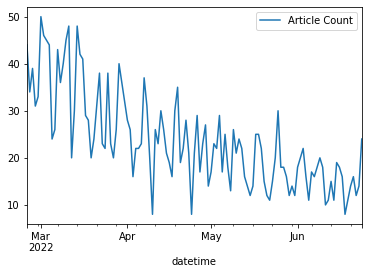

In [67]:
timeline.plot.line(x='datetime', y='Article Count')